# 

Copyright 2021 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ProbablyOverthinkingIt2/blob/master/berkson_college.ipynb)

I recently encountered a 2009 paper by Ceci, Williams, and Barnett, "[Women's underrepresentation in science: sociocultural and biological considerations](http://www2.psych.utoronto.ca/users/psy3001/files/Ceci%20&%20Williams.pdf)", which lists in the abstract these "factors unique to underrepresentation [of women] in math-intensive fields": 

> (a) Math-proficient women disproportionately prefer careers in non–math-intensive fields and are more likely to leave math-intensive careers as they advance; 
>
> (b) more men than women score in the extreme math-proficient range on gatekeeper tests, such as the SAT Mathematics and the Graduate Record Examinations Quantitative Reasoning sections; 
>
> (c) women with high math competence are disproportionately more likely to have high verbal competence, allowing greater choice of professions; and 
>
> (d) in some math-intensive fields, women with children are penalized in promotion rates.

To people familiar with this area of research, none of these are surprising, but the third caught my attention because [I recently looked at the correlation between math and verbal scores on the SAT and ACT](https://www.allendowney.com/blog/2021/04/07/berkson-goes-to-college/). In general, they are highly correlated, with $r$ around 0.7, and they are equally correlated for men and women. So I was curious to know where this claim comes from and, if it is true, how big a factor it might be.

As evidence, Ceci et at summarize results from "a tracking study of 1,100 high–mathematics aptitude students who expressed a goal of majoring in mathematics or science in college", which found that 

> One determinant of who switched out of math/science fields was the asymmetry between their verbal and mathematics abilities. Women's verbal abilities on average were nearly as strong as their mathematics abilities (only 61 points difference between their SAT-V and SAT-M), leading them to enter professions that prized verbal reasoning (e.g., law), whereas men's verbal abilities were an average of 115 points lower than their mathematics ability, possibly leading them to view mathematics as their only strength."

And they cite [Achter, Lubinski, Benbow, & Eftekhari-Sanjani, 1999](https://www.researchgate.net/publication/232571718_Assessing_Vocational_Preferences_among_Gifted_Adolescents_Adds_Incremental_Validity_to_Abilities_A_Discriminant_Analysis_of_Educational_Outcomes_over_a_10-Year_Interval) and
[Wai, Lubinski, & Benbow, 2005](https://www.psychologytoday.com/files/attachments/56143/creativity-and-occupational-accomplishments-among-intellectually-precocious-youths.pdf).

I don't have access to their data, but we can replicate their analysis with data from the [National Longitudinal Survey of Youth 1997](https://www.nlsinfo.org/content/cohorts/nlsy97) (NLSY97), which "follows the lives of a sample of [8,984] American youth born between 1980-84". The public data set includes the participants' scores on several standardized tests, including the SAT and ACT.
Assuming that most participants took these exams when they were 17, they probably took them between 1997 and 2001.

TODO:Summarize results


## Data

The following cell downloads the data file.

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/AllenDowney/ProbablyOverthinkingIt2/raw/master/' +
         'nlsy/stand_test_corr.csv.gz')

And I'll read the data into a Pandas `DataFrame`.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

nlsy = pd.read_csv('stand_test_corr.csv.gz')
nlsy.shape

(8984, 29)

In [3]:
nlsy.head()

,R0000100,R0536300,R0536401,R0536402,R1235800,R1482600,R5473600,R5473700,R7237300,R7237400,...,R9794001,R9829600,S1552600,S1552700,Z9033700,Z9033800,Z9033900,Z9034000,Z9034100,Z9034200
0,1,2,9,1981,1,4,-4,-4,-4,-4,...,1998,45070,-4,-4,4,3,3,2,-4,-4
1,2,1,7,1982,1,2,-4,-4,-4,-4,...,1998,58483,-4,-4,4,5,4,5,-4,-4
2,3,2,9,1983,1,2,-4,-4,-4,-4,...,-4,27978,-4,-4,2,4,2,4,-4,-4
3,4,2,2,1981,1,2,-4,-4,-4,-4,...,-4,37012,-4,-4,-4,-4,-4,-4,-4,-4
4,5,1,10,1982,1,2,-4,-4,-4,-4,...,-4,-4,-4,-4,2,3,6,3,-4,-4


The [columns are documented in the codebook](https://www.nlsinfo.org/investigator/pages/search?s=NLSY97).  The following dictionary maps the current column names to more memorable names. 

In [4]:
d = {'R9793200': 'psat_math',
     'R9793300': 'psat_verbal',
     'R9793400': 'act_comp',
     'R9793500': 'act_eng',
     'R9793600': 'act_math',
     'R9793700': 'act_read',
     'R9793800': 'sat_verbal',
     'R9793900': 'sat_math',
     'R0536300': 'sex',
    }

nlsy.rename(columns=d, inplace=True)

There are 4599 male and 4385 female participants.

In [5]:
nlsy['sex'].value_counts()

1    4599
2    4385
Name: sex, dtype: int64

In [7]:
male = nlsy[nlsy['sex'] == 1]
female = nlsy[nlsy['sex'] == 2]

## SAT

The SAT data includes a few cases where the scores are less than 200, so let's clean those up.

In [6]:
varnames = ['sat_verbal', 'sat_math']

for varname in varnames:
    invalid = (nlsy[varname] < 200)
    nlsy.loc[invalid, varname] = np.nan

1400 of the participants took the SAT.  Their average and standard deviation are close to the national average (500) and standard deviation (100).

In [8]:
nlsy['sat_verbal'].describe()

count    1400.000000
mean      501.678571
std       108.343678
min       200.000000
25%       430.000000
50%       500.000000
75%       570.000000
max       800.000000
Name: sat_verbal, dtype: float64

In [57]:
nlsy['sat_math'].describe()

count    1399.000000
mean      503.213009
std       109.901382
min       200.000000
25%       430.000000
50%       500.000000
75%       580.000000
max       800.000000
Name: sat_math, dtype: float64

On the verbal section, the male and female averages are roughly the same.
The male scores are a little more variable.


In [60]:
male['sat_verbal'].describe()

count    649.000000
mean     502.681048
std      111.764295
min      200.000000
25%      430.000000
50%      500.000000
75%      580.000000
max      800.000000
Name: sat_verbal, dtype: float64

In [59]:
female['sat_verbal'].describe()

count    751.000000
mean     500.812250
std      105.365425
min      200.000000
25%      430.000000
50%      490.000000
75%      570.000000
max      800.000000
Name: sat_verbal, dtype: float64

On the math section the male average is substantially higher (518 compared to 491) and the male scores are substantially more variable (std 115 compared to 104).

In [11]:
male['sat_math'].describe()

count    648.000000
mean     517.608025
std      114.682496
min      220.000000
25%      440.000000
50%      520.000000
75%      600.000000
max      800.000000
Name: sat_math, dtype: float64

In [12]:
female['sat_math'].describe()

count    751.000000
mean     490.792277
std      104.089408
min      200.000000
25%      420.000000
50%      480.000000
75%      550.000000
max      790.000000
Name: sat_math, dtype: float64

The correlation between the sections is high, about 0.73 overall.

In [13]:
nlsy[varnames].corr()

,sat_verbal,sat_math
sat_verbal,1.000000,0.734739
sat_math,0.734739,1.000000


And the correlation is about the same for both groups.

In [61]:
male[varnames].corr()

,sat_verbal,sat_math
sat_verbal,1.000000,0.736466
sat_math,0.736466,1.000000


In [15]:
female[varnames].corr()

,sat_verbal,sat_math
sat_verbal,1.000000,0.742472
sat_math,0.742472,1.000000


## Regression

Although the correlations are the same, the regression lines are not.

In [16]:
def decorate(**options):
    """Decorate the current axes.
    
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
             
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    ax = plt.gca()
    ax.set(**options)
    
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels)

    plt.tight_layout()

In [17]:
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess

def make_lowess(x, y):
    """Use LOWESS to compute a smooth line.
    
    series: pd.Series
    
    returns: pd.Series
    """
    #y = series.values
    #x = series.index.values

    smooth = lowess(y, x)
    index, data = np.transpose(smooth)

    return pd.Series(data, index=index) 

In [18]:
def plot_lowess(df, color='C0', **options):
    x, y = df['sat_math'], df['sat_verbal']
    plt.plot(x, y, '.', 
             ms=2, alpha=0.2, color=color)
    smooth = make_lowess(x, y)
    smooth.plot(color=color, **options)

    decorate(xlabel='SAT Math',
             ylabel='SAT Math - Verbal',
             title='Difference vs math score')

The following figure shows a scatterplot of verbal and math scores for male and female participants, along with a local regression line.

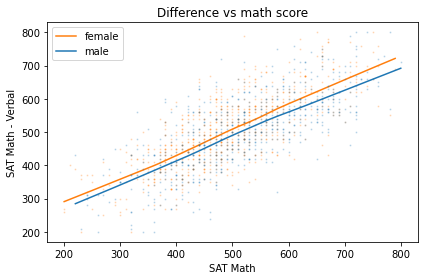

In [19]:
plot_lowess(female, 'C1', label='female')
plot_lowess(male, label='male')

For a given math score, the female participants have a higher verbal score, and this gap seems to be wider at the high end of the range.

For male participants who got a 750 on the math section, the average score on the verbal section is 659.

In [62]:
smooth = make_lowess(male['sat_math'], male['sat_verbal'])
smooth[750]

658.8914941639335

In [20]:
750 - smooth[750]

91.10850583606646

For female participants who got a 750 on the math section, the average score one the verbal section is 693.

In [63]:
smooth = make_lowess(female['sat_math'], female['sat_verbal'])
smooth[750]

750.0    693.277281
750.0    693.277281
750.0    693.277281
dtype: float64

In [21]:
750 - smooth[750]

750.0    56.722719
750.0    56.722719
750.0    56.722719
dtype: float64

This is consistent with the result Ceci et al reported from a previous study: 

> Women's verbal abilities on average were nearly as strong as their mathematics abilities (only 61 points difference between their SAT-V and SAT-M), leading them to enter professions that prized verbal reasoning (e.g., law), whereas men's verbal abilities were an average of 115 points lower than their mathematics ability, possibly leading them to view mathematics as their only strength.

In the NLSY dataset, these differences are a little smaller, 57 points for women and 91 for men.
So we might ask

1. Is this a big enough difference that it seems likely to affect career choices? For example, suppose Student A has scores M 750 V 660 and Student B has scores M 750 V 690. Do you think A would be substantially more likely than B to "view mathematics as their only strength"?

2. If we assume that the answer is yes, and that both students make career choices accordingly, how big an effect would this have on the sex ratios we see in math-intensive fields?

I don't have the data to answer the first question, but we can use the data we have, and a model of the filtering processes, to put an upper bound on the second.


## Simulating the filtering process

As a super simple model of the world, let's suppose that there are two math-intensive jobs:

* A math-intensive job that requires a math SAT score of 700 or more.

* A math-and-verbal-intensive job that requires a math SAT score of 700 or more AND a verbal SAT score of 700 or more.

And let's suppose that these jobs are so appealing that

* If someone is qualified for the math-and-verbal job, they will choose to do it;

* Otherwise, if they are qualified for the math job, they will choose to do it;

* Otherwise they will do something else.

The following function simulates this filtering process, computing:

* The number of people who meet the math requirement, and their fraction of the population,

* The fraction of people who meet the verbal requirement, given that they meet the math requirement.

* The number of people who meet the math requirement and NOT the verbal requirement, and their fraction of the population, 


In [69]:
def simulate_filter(df, thresh_math, thresh_verbal):
    subset = df.dropna(subset=['sat_math', 'sat_verbal'])
    
    high_math = subset['sat_math'] >= thresh_math
    high_verbal = subset['sat_verbal'] >= thresh_verbal
    
    n = len(subset)
    n_math = high_math.sum()
    n_math_and_verbal = (high_math & high_verbal).sum()
    n_math_no_verbal = (high_math & ~high_verbal).sum()
    
    result = dict(n=n, n_math=n_math, n_math_no_verbal=n_math_no_verbal,
                  pct_math=n_math/n*100,
                  pct_math_no_verbal=n_math_no_verbal/n*100,
                  pct_verbal_given_math = n_math_and_verbal/n_math*100,
                  )
    
    return result

Among male participants, 6.2% meet the math requirement; 30% of them also meet the verbal requirement, which means that 4.3% of male participants meet the math requirement and NOT the verbal requirement.

In [70]:
percents_male = simulate_filter(male, 700, 700)
percents_male

{'n': 648,
 'n_math': 40,
 'n_math_no_verbal': 28,
 'pct_math': 6.172839506172839,
 'pct_verbal_given_math': 30.0,
 'pct_math_no_verbal': 4.320987654320987}

Among female participants, 3.5% meet the math requirement; 38% of them also meet the verbal requirement, which means that 2.1% of female participants meet the math requirement and NOT the verbal requirement.

In [71]:
percents_female = simulate_filter(female, 700, 700)
percents_female

{'n': 750,
 'n_math': 26,
 'n_math_no_verbal': 16,
 'pct_math': 3.4666666666666663,
 'pct_verbal_given_math': 38.46153846153847,
 'pct_math_no_verbal': 2.1333333333333333}

## Predicting sex ratios

We can use the percentages in the previous section to compute the sex ratios we would see in the second job, the one that requires a high math score only.

In the following function, `ratio1` is the ratio of men to women who meet the math requirement; `ratio2` is the ratio of men to women who meet the math requirement and NOT the verbal requirement.

In [74]:
def compute_ratios(pct1, pct2):
    result = {}
    result['sex_ratio1'] = pct1['pct_math'] / pct2['pct_math']
    result['verbal_ratio'] = pct2['pct_verbal_given_math'] / pct1['pct_verbal_given_math']
    result['sex_ratio2'] = pct1['pct_math_no_verbal'] / pct2['pct_math_no_verbal']
    result['factor_c'] = result['sex_ratio2'] / result['sex_ratio1']
    return result

In [78]:
pprint(compute_ratios(percents_male, percents_female))

{'factor_c': 1.1374999999999997,
 'sex_ratio1': 1.7806267806267808,
 'sex_ratio2': 2.025462962962963,
 'verbal_ratio': 1.2820512820512822}


These results are consistent with factors (b) and (c) as listed by Ceci et al. Again:

> (b) more men than women score in the extreme math-proficient range on gatekeeper tests, such as the SAT Mathematics and the Graduate Record Examinations Quantitative Reasoning sections; 
>
> (c) women with high math competence are disproportionately more likely to have high verbal competence, allowing greater choice of professions; and 

In this dataset, men are 1.8 times more likely to have an SAT score of 700 or more.
But women who meet the math requirement are 1.3 times more likely to ALSO meet the verbal requirement.

So in a job that has a math requirement but no verbal requirement, we expect to find a sex ratio near 2:1, that is, 2 men for every 1 woman.

Under these conditions, the effect of factor (c) is to increase the sex ratio in the math-intensive job from 1.8 to 2.0, an increase of 14%.

For this analysis, I set both threshold scores to 700 so that the number of participants that meet the requirements is big enough to make reasonable estimates of these ratios.
But if we make the thresholds any higher, we get into very small sample sizes.
So, before we go on, I will extrapolate the dataset using a Gaussian model.

## Extending the model into the tails

The following function takes a dataset and computes the summary statistics we'll need to compute the model:

* The mean and standard deviation of both test scores.

* A regression model of verbal scores as a function of math scores, including the slope and intercept of the best fit line and the standard deviation of the residuals.

In [27]:
from scipy.stats import linregress

def run_regress(df):
    subset = df.dropna(subset=['sat_math', 'sat_verbal'])

    x = subset['sat_math']
    y = subset['sat_verbal']
    model = linregress(x, y)._asdict()
    
    model['x_bar'] = x.mean()
    model['y_bar'] = y.mean()
    model['std_x'] = x.std()
    model['std_y'] = y.std()
    model['std_resid'] = np.sqrt(y.std()**2 * (1-model['rvalue']**2))
    model['diff'] = 750 - (model['slope'] * 750 + model['intercept'])
    
    return model

Here are the results for male and female participants.

In [28]:
model_male = run_regress(male)
model_male

{'slope': 0.7178981765301716,
 'intercept': 131.23421699076414,
 'rvalue': 0.7364655846849872,
 'pvalue': 9.366475010436844e-112,
 'stderr': 0.025944535141853017,
 'intercept_stderr': 13.754270755516483,
 'x_bar': 517.608024691358,
 'y_bar': 502.8240740740741,
 'std_x': 114.68249590043382,
 'std_y': 111.79117721035935,
 'std_resid': 75.62393800388467,
 'diff': 80.34215061160717}

In [29]:
model_female = run_regress(female)
model_female

{'slope': 0.7529532783615287,
 'intercept': 131.58465185439144,
 'rvalue': 0.7424724177662607,
 'pvalue': 2.7404858746767917e-132,
 'stderr': 0.024838864388664287,
 'intercept_stderr': 12.454336396031112,
 'x_bar': 490.53333333333336,
 'y_bar': 500.93333333333334,
 'std_x': 103.91653903494971,
 'std_y': 105.38344168763642,
 'std_resid': 70.59390551775333,
 'diff': 53.70038937446202}

We have seen most of these statistics before, but the regression parameters are new. Note that the slope of the regression line is 0.75 for women and 0.72 for men, which means that each additional point on the math section corresponds to a bigger fraction of a point on the verbal section.
And that's consistent with what we saw using local regression.

## Resampling

Now we can use these models to simulate larger datasets, which will make it possible to explore farther into the tails.
The following function takes a model and uses Gaussian distributions to generate a sample with the same parameters.

In [30]:
from scipy.stats import norm

def resample_normal(model, n):
    mu_x = model['x_bar']
    sigma_x = model['std_x']
    xs = norm(mu_x, sigma_x).rvs(n)
    over700 = norm(mu_x, sigma_x).sf(700)
    print(over700)
    
    mu_y = xs * model['slope'] + model['intercept']
    sigma_y = model['std_resid']
    ys = norm(mu_y, sigma_y).rvs(n)
    
    return pd.DataFrame(dict(sat_math=xs, sat_verbal=ys))

Here's a sample based on the male model.

In [31]:
sample_male = resample_normal(model_male, 1000000)
sample_male.head()

0.05587141804055689


,sat_math,sat_verbal
0,387.302760,382.893722
1,477.007400,436.830116
2,409.157421,299.379162
3,356.363330,344.758712
4,480.158942,519.137790


And we can confirm that the summary statistics are about right.

In [33]:
run_regress(sample_male)

{'slope': 0.7175831229887027,
 'intercept': 131.3596631397806,
 'rvalue': 0.7363311425895356,
 'pvalue': 0.0,
 'stderr': 0.0006593942824992125,
 'intercept_stderr': 0.34962567981745407,
 'x_bar': 517.6590344041399,
 'y_bar': 502.82304969081963,
 'std_x': 114.73895813068215,
 'std_y': 111.8175439576405,
 'std_resid': 75.65813731303767,
 'diff': 80.4529946186924}

Compared to the model it is based on.

In [32]:
model_male

{'slope': 0.7178981765301716,
 'intercept': 131.23421699076414,
 'rvalue': 0.7364655846849872,
 'pvalue': 9.366475010436844e-112,
 'stderr': 0.025944535141853017,
 'intercept_stderr': 13.754270755516483,
 'x_bar': 517.608024691358,
 'y_bar': 502.8240740740741,
 'std_x': 114.68249590043382,
 'std_y': 111.79117721035935,
 'std_resid': 75.62393800388467,
 'diff': 80.34215061160717}

Here's a sample based on the female model.

In [34]:
sample_female = resample_normal(model_female, 1000000)
sample_female.head()

0.021914621151376847


,sat_math,sat_verbal
0,684.328814,717.276752
1,795.117040,729.292258
2,722.171356,667.751263
3,343.408844,391.977090
4,370.004158,299.595367


And we can confirm that the summary statistics are about right.

In [36]:
run_regress(sample_female)

{'slope': 0.7543600281986982,
 'intercept': 130.9059827833413,
 'rvalue': 0.7434084889019449,
 'pvalue': 0.0,
 'stderr': 0.0006786913385259994,
 'intercept_stderr': 0.3402665674432956,
 'x_bar': 490.46675980189747,
 'y_bar': 500.8945015380248,
 'std_x': 103.92825780932522,
 'std_y': 105.45927933575827,
 'std_resid': 70.53513786804243,
 'diff': 53.32399606763511}

Compared to the model it's based on.

In [35]:
model_female

{'slope': 0.7529532783615287,
 'intercept': 131.58465185439144,
 'rvalue': 0.7424724177662607,
 'pvalue': 2.7404858746767917e-132,
 'stderr': 0.024838864388664287,
 'intercept_stderr': 12.454336396031112,
 'x_bar': 490.53333333333336,
 'y_bar': 500.93333333333334,
 'std_x': 103.91653903494971,
 'std_y': 105.38344168763642,
 'std_resid': 70.59390551775333,
 'diff': 53.70038937446202}

## Computing percents and ratios

Now let's check whether the samples we generated yield similar results when we compute sex ratios.
Here's what we get when we use the male sample to simulate the filtering process.

In [80]:
thresh = 700
percents_male = simulate_filter(sample_male, thresh, thresh)
percents_male

{'n': 1000000,
 'n_math': 56321,
 'n_math_no_verbal': 36897,
 'pct_math': 5.6321,
 'pct_verbal_given_math': 34.48802400525559,
 'pct_math_no_verbal': 3.6896999999999998}

And let's compare it to the results with the actual data.

In [81]:
simulate_filter(male, thresh, thresh)

{'n': 648,
 'n_math': 40,
 'n_math_no_verbal': 28,
 'pct_math': 6.172839506172839,
 'pct_verbal_given_math': 30.0,
 'pct_math_no_verbal': 4.320987654320987}

It turns out that there are discrepancies bigger than we would expect due to random sampling. For example, in the original dataset, 5.6% of male participants meet the math requirement; in the resampled data, it's 6.2%.

We'll see what's going on in the next section, but first let's run the same analysis with the sample based on the female model:


In [82]:
percents_female = simulate_filter(sample_female, thresh, thresh)
percents_female

{'n': 1000000,
 'n_math': 21946,
 'n_math_no_verbal': 12500,
 'pct_math': 2.1946,
 'pct_verbal_given_math': 43.04201221179258,
 'pct_math_no_verbal': 1.25}

And compare it with the results from the female data.

In [83]:
simulate_filter(female, thresh, thresh)

{'n': 750,
 'n_math': 26,
 'n_math_no_verbal': 16,
 'pct_math': 3.4666666666666663,
 'pct_verbal_given_math': 38.46153846153847,
 'pct_math_no_verbal': 2.1333333333333333}

Again, there are non-negligible differences.
And these differences also affect the predicted sex ratios.

In [41]:
compute_ratios(percents_male, percents_female)

(2.566344664175704, 2.9517599999999997, 1.1501806601445286)

In the Gaussian model, male participants are 2.6 times more likely to meet the math requirement (compared to 1.8 in the actual data) and the sex ratio we expect in the math-intensive job is almost 3 (compared to 2.0 in the actual data).

## What's going on?

To see what's going on, let's compare the distribution of math scores in the original data and in the Gaussian model.
Here are the distributions for the male participants.

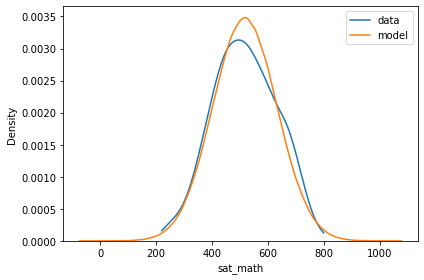

In [85]:
import seaborn as sns

sns.kdeplot(male['sat_math'], cut=0, label='data')
sns.kdeplot(sample_male['sat_math'], label='model')

decorate()

Based on the mean and standard deviation of SAT scores, we expect the tails to extend below 200 and above 800.
But SAT scores are truncated at these bounds, and the scores are somewhat less accurate above 700 and below 300, compared to scores closer to the mean.
So people who might score 810 on an exam with wider range end up spread out in the 700s, more or less at random, based on the results from a small number of questions.

As a result, the Gaussian model departs from the data in the tails.
We see the same effect for female participants.




SAT scores are truncated at 200 and 800, but the values from the Gaussian



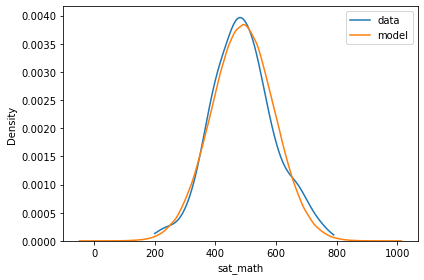

In [86]:
sns.kdeplot(female['sat_math'], cut=0, label='data')
sns.kdeplot(sample_female['sat_math'], label='model')

decorate()

The truncation of SAT scores at the high end has a substantial effect on the predicted sex ratios in a math-intensive job.
In particular, it seems to mitigate the effect of the filtering processes, compared to a test that extends farther into the tails.

Nevertheless, we can use the Gaussian model to see what happens if we increase the threshold, assuming that it is based on a test that extends farther into the tails as, for example, the GRE might.

## Higher threshold

If we increase the thresholds to 750, fewer people satisfy the requirements.

In [87]:
thresh = 750
percents_male = simulate_filter(sample_male, thresh, thresh)
percents_male

{'n': 1000000,
 'n_math': 21441,
 'n_math_no_verbal': 15796,
 'pct_math': 2.1441000000000003,
 'pct_verbal_given_math': 26.328063056760413,
 'pct_math_no_verbal': 1.5796000000000001}

In [88]:
percents_female = simulate_filter(sample_female, thresh, thresh)
percents_female

{'n': 1000000,
 'n_math': 6234,
 'n_math_no_verbal': 4083,
 'pct_math': 0.6234,
 'pct_verbal_given_math': 34.50433108758422,
 'pct_math_no_verbal': 0.4083}

And the sex ratio in math-intensive jobs gets higher.

In [90]:
compute_ratios(percents_male, percents_female)

{'sex_ratio1': 3.4393647738209827,
 'verbal_ratio': 1.310553344285019,
 'sex_ratio2': 3.868723977467549,
 'factor_c': 1.1248367741958254}

With this threshold, male participants are 3.4 times more likely to meet the math requirement, but female participants who meet the math requirement are 1.3 times more likely to ALSO meet the verbal requirement.

If all people who meet both requirements choose a different job, the sex ratio we expect to see in the math intensive job is about 3.9 : 1.
Again, the effect of factor (c) is to increase the sex ratio by about 12%.

If we increase the threshold to 800, fewer than 1% of people meet either requirement.

In [91]:
thresh = 800
percents_male = simulate_filter(sample_male, thresh, thresh)
percents_male

{'n': 1000000,
 'n_math': 6892,
 'n_math_no_verbal': 5549,
 'pct_math': 0.6891999999999999,
 'pct_verbal_given_math': 19.48636099825885,
 'pct_math_no_verbal': 0.5549000000000001}

In [92]:
percents_female = simulate_filter(sample_female, thresh, thresh)
percents_female

{'n': 1000000,
 'n_math': 1421,
 'n_math_no_verbal': 1035,
 'pct_math': 0.1421,
 'pct_verbal_given_math': 27.16396903589022,
 'pct_math_no_verbal': 0.1035}

And the sex ratios are higher.

In [93]:
compute_ratios(percents_male, percents_female)

{'sex_ratio1': 4.850105559465165,
 'verbal_ratio': 1.393999066234962,
 'sex_ratio2': 5.361352657004832,
 'factor_c': 1.10540947846835}

With this thresholds, male participants are almost 4.9 times more likely to meet the math requirement, but female participants who meet the math requirement are 1.4 times more likely to ALSO meet the verbal requirement.

If all people who meet both requirements choose a different job, the sex ratio we expect to see in the math-intensive job is about 5.4 : 1.
The effect of factor (c) is to increase the sex ratio by about 10%.

In summary, the more strict the math and verbal requirements are, the larger the effect of factor (b).
At every level, factor (c) has the effect of increasing the sex ratio we expect in a math intensive job, but the increase is only 10-15%, and might get smaller as the requirements get stricter.

And this is probably an upper bound on the effect of factor (c), since it assumes that everyone who qualifies for the verbal-intensive job chooses to do it instead of the math-intensive job.

## What if?


In [50]:
compute_ratios(percents_male, percents_female)

(4.850105559465165, 5.361352657004832, 1.10540947846835)

In [51]:
model_male1 = model_male.copy()
model_male1['x_bar'] = model_female['x_bar']
model_male1

{'slope': 0.7178981765301716,
 'intercept': 131.23421699076414,
 'rvalue': 0.7364655846849872,
 'pvalue': 9.366475010436844e-112,
 'stderr': 0.025944535141853017,
 'intercept_stderr': 13.754270755516483,
 'x_bar': 490.53333333333336,
 'y_bar': 502.8240740740741,
 'std_x': 114.68249590043382,
 'std_y': 111.79117721035935,
 'std_resid': 75.62393800388467,
 'diff': 80.34215061160717}

In [52]:
from pprint import pprint

def run_analysis(model_male, percents_female, thresh=800):
    sample_male = resample_normal(model_male, 1000000)
    percents_male = simulate_filter(sample_male, thresh, thresh)
    pprint(percents_male)

    ratios = compute_ratios(percents_male, percents_female)
    print(ratios)

In [53]:
run_analysis(model_male1, percents_female)

0.03388808908389575
{'n': 1000000,
 'n_math': 3493,
 'n_math_no_verbal': 2793,
 'pct_math': 0.003493,
 'pct_math_no_verbal': 0.002793,
 'pct_verbal_given_math': 0.20040080160320642}
(2.458128078817734, 2.6985507246376814, 1.097807208620139)


In [54]:
model_male2 = model_male.copy()
model_male2['std_x'] = model_female['std_x']
run_analysis(model_male2, percents_female)

0.03961447223698165
{'n': 1000000,
 'n_math': 3266,
 'n_math_no_verbal': 2712,
 'pct_math': 0.003266,
 'pct_math_no_verbal': 0.002712,
 'pct_verbal_given_math': 0.1696264543784446}
(2.2983814215341307, 2.620289855072464, 1.1400587520079521)


In [55]:
model_male3 = model_male.copy()
model_male3['x_bar'] = model_female['x_bar']
model_male3['std_x'] = model_female['std_x']
run_analysis(model_male3, percents_female)

0.021914621151376847
{'n': 1000000,
 'n_math': 1409,
 'n_math_no_verbal': 1178,
 'pct_math': 0.001409,
 'pct_math_no_verbal': 0.001178,
 'pct_verbal_given_math': 0.16394606103619588}
(0.99155524278677, 1.1381642512077297, 1.1478576302102084)


In [56]:
model_male4 = model_male.copy()
model_male4['x_bar'] = model_female['x_bar']
model_male4['std_x'] = model_female['std_x']
model_male4['slope'] = 0.75
run_analysis(model_male4, percents_female)

0.021914621151376847
{'n': 1000000,
 'n_math': 1454,
 'n_math_no_verbal': 1051,
 'pct_math': 0.001454,
 'pct_math_no_verbal': 0.001051,
 'pct_verbal_given_math': 0.27716643741403024}
(1.0232230823363828, 1.0154589371980678, 0.9924120699851818)
